In [1]:
# The MIT License (MIT) Copyright (c) 2025 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/10_Word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Word embeddings
- Word Embeddings es una técnica popular en procesamiento del lenguaje natural que permite representar las palabras en un espacio vectorial.
  
- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [2]:
import torch
import pandas as pd

torch.__version__

'2.5.1+cu124'

In [3]:
torch.manual_seed(77)

## 1.- Conjuntos de entrenamiento y validación

In [4]:
df = pd.read_csv('./cyberbullying_tweets.csv')   

In [5]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [7]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [8]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 1,
    'other_cyberbullying': 1,
    'age': 1,
    'ethnicity': 1
}

df['cyberbullying_type'] = df['cyberbullying_type'].map(labels_dict)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
df['tweet_text'] = df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,0
1,why is aussietv so white mkr theblock imaceleb...,0
2,xochitlsuckkks a classy whore or more red velv...,0
3,jasongio meh p thanks for the heads up but no...,0
4,rudhoeenglish this is an isis account pretendi...,0


In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size = 0.15, random_state = 123)

In [12]:
train_df['cyberbullying_type'].value_counts()

cyberbullying_type
1    33712
0     6826
Name: count, dtype: int64

## 2.- Pipeline

- Crea vocabulario y define tokenizer.

In [13]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

# Define a WordLevel tokenizer with unk_token
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Create a WordLevelTrainer and specify special tokens (including [UNK])
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]"], min_frequency=1)


# Train the tokenizer on your text data, using the trainer
tokenizer.train_from_iterator(train_df["tweet_text"], trainer=trainer)

# Now you can encode your text
text = "Hello, how are you?"
encoding = tokenizer.encode(text)

# Access the token IDs
print("Token IDs:", encoding.ids)

# Decode the token IDs back to words
decoded_text = tokenizer.decode(encoding.ids)
print("Decoded Text:", decoded_text)

Token IDs: [0, 0, 71, 13, 7, 0]
Decoded Text: how are you


In [14]:
vocab_size = tokenizer.get_vocab_size()
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 30000


In [15]:
maxlen = 64

def data_process(x, y):
    data = []
    for raw_txt, target in zip(x, y):
        token_ids = tokenizer.encode(raw_txt).ids  # Convert text to token IDs
        tensor_ = torch.tensor(token_ids, dtype=torch.long)
        if tensor_.shape[0] <= maxlen:
            target_ = torch.tensor(target, dtype=torch.int64)  # Ensure correct dtype
            data.append((tensor_, target_))
    return data

train_data = data_process(train_df.tweet_text.values, 
                          train_df.cyberbullying_type.values)
val_data = data_process(val_df.tweet_text.values, 
                        val_df.cyberbullying_type.values)

len(train_data), len(val_data)

(40485, 7145)

In [16]:
train_data[0]

(tensor([  44,    7,   14,  201,    9,  560,    6,  127, 1086,   33,    2,   76,
            7,  118,   67, 4300,   75,   29,    6,   38,    9,   32,   15,   23,
           72, 2475, 2804, 1130,    7,   14,  201,  523,   62,  632,  803,  953,
           23, 2015]),
 tensor(1))

In [17]:
PAD_IDX = tokenizer.token_to_id("[PAD]") 
PAD_IDX

1

In [18]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Fixes the warning by preventing parallelism conflicts

In [19]:
batch_size = 128

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        x.append(x_item)
        y.append(y_item)

    x = pad_sequence(x, batch_first=True, padding_value=PAD_IDX)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y



train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, collate_fn=generate_batch, 
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                        shuffle=True, collate_fn=generate_batch,
                        num_workers=4, pin_memory=True)


In [20]:
%%timeit
train_batch, target_batch = next(iter(train_loader))

62 ms ± 290 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
train_batch, target_batch = next(iter(train_loader))

In [22]:
train_batch.shape, target_batch.shape

(torch.Size([128, 62]), torch.Size([128]))

## 3.- Modelo

In [23]:
import torch.nn as nn

In [24]:
class Model(nn.Module):
    def __init__(self, vocab_size):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(128, 16)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu3 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.pooling(x).squeeze()
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        x = self.relu3(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = Model(vocab_size)
output_batch = model(train_batch)

In [25]:
output_batch.shape, output_batch.squeeze().shape

(torch.Size([128, 1]), torch.Size([128]))

## 4.- Entrenamiento

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


Model(
  (embedding): Embedding(30000, 128)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (relu1): ReLU()
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu3): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [27]:
from torch import optim

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

In [29]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [30]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = loss_fn(outputs, labels)
            outputs = torch.round(outputs)
            running_acc += outputs.eq(labels).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:.4f} sec Val loss: {running_loss / len(test_loader):.4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):.4f}')

In [31]:
import time

In [32]:
epochs = 7

for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)


Time for epoch 0 is 0.7648 sec Train loss: 0.4453
Time for eval is 0.1336 sec Val loss: 0.3331
Val acc: 0.8435

Time for epoch 1 is 0.6007 sec Train loss: 0.3142
Time for eval is 0.1168 sec Val loss: 0.2959
Val acc: 0.8477

Time for epoch 2 is 0.5829 sec Train loss: 0.2743
Time for eval is 0.1127 sec Val loss: 0.2739
Val acc: 0.8599

Time for epoch 3 is 0.6043 sec Train loss: 0.2496
Time for eval is 0.1141 sec Val loss: 0.2737
Val acc: 0.8501

Time for epoch 4 is 0.5814 sec Train loss: 0.2312
Time for eval is 0.1173 sec Val loss: 0.2698
Val acc: 0.8557

Time for epoch 5 is 0.6132 sec Train loss: 0.2133
Time for eval is 0.1198 sec Val loss: 0.2669
Val acc: 0.8715

Time for epoch 6 is 0.6407 sec Train loss: 0.2004
Time for eval is 0.1220 sec Val loss: 0.2766
Val acc: 0.8540


## 5.- Vectores

In [33]:
# Define the list of words
words = ["bad", "good", "hate", "happy", "love", "scared", "friend", "sad", 
         "alive", "family", "confident", "fight", "live", "funny", "best", 
         "great", "amazing"]

# Convert words to token IDs
words_ids = torch.tensor([tokenizer.encode(word).ids[0] for word in words], dtype=torch.long)

words_ids


tensor([ 176,  142,  135,  459,  163,  814,  310,  552, 1162,  403, 2845,  379,
         413,  181,  327,  372,  816])

In [34]:
model.to('cpu')
model.eval()

Model(
  (embedding): Embedding(30000, 128)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (relu1): ReLU()
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu3): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [35]:
embeddings = model.embedding(words_ids).detach()
embeddings.shape

torch.Size([17, 128])

- Visualización de los vectores aprendidos

(17, 2)


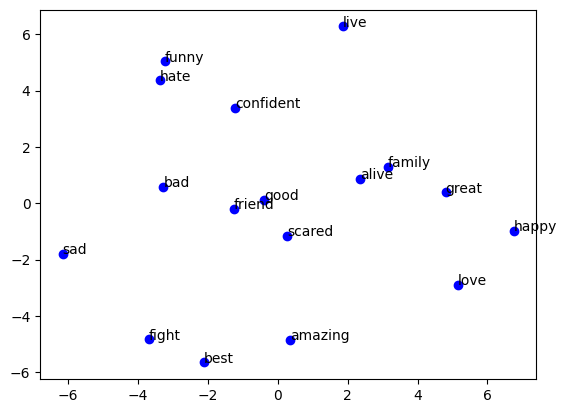

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
    
plt.show()